# Social acceptance of wind and impact on deployment

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from typing import Type
import random
import statsmodels.formula.api as st_mdl
from math import pi, exp
%matplotlib inline

## Setting up the environment

In [249]:
# Read Illinois shape file and create a geopanda data frame
il = gpd.read_file('./ilinois2/2010_Illinois_County_TotalPopulationDensity.shp')
df = pd.DataFrame(il)
geo_df = gpd.GeoDataFrame(df)
geo_df.head()

,TotPopDens,County,State,TotPopNum,AREAsqmi,FIPS_Cnty,geometry
0,37.229000,Jo Daviess,Illinois,22678.0,609.147602,17085,"POLYGON ((-89.92558 42.50751, -89.92466 42.458..."
1,86.183800,Stephenson,Illinois,47711.0,553.595891,17177,"POLYGON ((-89.40308 42.50300, -89.40128 42.463..."
2,573.309998,Winnebago,Illinois,295266.0,515.019710,17201,"POLYGON ((-89.36452 42.50294, -89.31850 42.502..."
3,510.584991,McHenry,Illinois,308760.0,604.717660,17111,"POLYGON ((-88.30162 42.49791, -88.19713 42.498..."
4,194.406006,Boone,Illinois,54165.0,278.618125,17007,"POLYGON ((-88.77372 42.49575, -88.77185 42.495..."


In [250]:
# Initialize random seed
np.random.seed(0)

def trunc_normal_distrib_draw(
        min_distrib: float, max_distrib: float, mean: float,
        standard_deviation: float) -> float:
    """
    Draw a value from a truncated normal distribution.
    :param min_distrib: minimum of the range from where to draw.
    :param max_distrib: maximum of the range from where to draw.
    :param mean: mean of the distribution.
    :param standard_deviation: standard deviation of the distribution.
    :return: drawn value.
    """
    a = (min_distrib - mean) / standard_deviation
    b = (max_distrib - mean) / standard_deviation
    loc = mean
    scale = standard_deviation
    distribution = truncnorm(a, b, loc, scale)
    draw = float(distribution.rvs(1))
    return draw

# Bessette & Mills approximate data (using truncated normal distribution based on Bessette & Mills summary statistics 
# and not actual data)
geo_df['percent_prod'] = np.nan
geo_df['percent_prod'] = geo_df['percent_prod'].apply(lambda x: trunc_normal_distrib_draw(0, 100, 25, 8))
geo_df['percent_rep'] = np.nan
geo_df['percent_rep'] = geo_df['percent_rep'].apply(lambda x: trunc_normal_distrib_draw(0, 100, 63, 7))
geo_df['amenities'] = np.nan
geo_df['amenities'] = geo_df['amenities'].apply(lambda x: trunc_normal_distrib_draw(1, 4, 2.2, 0.72))
geo_df['illinois'] = np.where(df['State'] == 'Illinois', True, False)
intercept = 9.77
percent_prod_beta = -0.145
percent_rep_beta = -0.077
amenity_beta = 1.599
illinois_beta = 2.4

# Bessette & Mills approximate model (only keeping significant independent variables)
geo_df['contention'] = (intercept + percent_prod_beta * geo_df['percent_prod'] + 
                        percent_rep_beta * geo_df['percent_rep'] + amenity_beta * geo_df['amenities'] +
                        illinois_beta * geo_df['illinois'])

# Average wind speed placeholder (m/s)
geo_df['wind_speed'] = np.nan
geo_df['wind_speed'] = geo_df['wind_speed'].apply(lambda x: trunc_normal_distrib_draw(4, 6, 5, 1))

# Maximum of new wind turbines placeholder
# Assumes only 20% of total area is available
# Assumes a new wind plant turbine takes 2/10 of a square mile 
# (https://sciencing.com/much-land-needed-wind-turbines-12304634.html)
land_use_turbine = 2 / 10  # square mile / turbine
geo_df['percent_area_avbl'] = np.nan
geo_df['percent_area_avbl'] = geo_df['percent_area_avbl'].apply(lambda x: trunc_normal_distrib_draw(0, 0.2, 0.1, 0.01))
geo_df['max_n_turbine'] = (geo_df['AREAsqmi'] * geo_df['percent_area_avbl'] / land_use_turbine).astype(int)

# Correct model results so that contention is between 0 and 10
geo_df['contention'] = np.where(geo_df['contention'] > 10, 10, geo_df['contention'])
geo_df['contention'] = np.where(geo_df['contention'] < 0, 0, geo_df['contention'])

geo_df.head()

,TotPopDens,County,State,TotPopNum,AREAsqmi,FIPS_Cnty,geometry,percent_prod,percent_rep,amenities,illinois,contention,wind_speed,percent_area_avbl,max_n_turbine
0,37.229000,Jo Daviess,Illinois,22678.0,609.147602,17085,"POLYGON ((-89.92558 42.50751, -89.92466 42.458...",25.989419,67.400188,1.143487,True,5.040155,4.322685,0.102910,313
1,86.183800,Stephenson,Illinois,47711.0,553.595891,17177,"POLYGON ((-89.40308 42.50300, -89.40128 42.463...",29.554845,75.436670,1.322268,True,4.190231,4.140852,0.081626,225
2,573.309998,Winnebago,Illinois,295266.0,515.019710,17201,"POLYGON ((-89.36452 42.50294, -89.31850 42.502...",27.091378,58.251069,2.558025,True,7.846699,5.396172,0.078456,202
3,510.584991,McHenry,Illinois,308760.0,604.717660,17111,"POLYGON ((-88.30162 42.49791, -88.19713 42.498...",25.910117,64.344508,2.158445,True,6.909859,4.031738,0.098206,296
4,194.406006,Boone,Illinois,54165.0,278.618125,17007,"POLYGON ((-88.77372 42.49575, -88.77185 42.495...",23.470047,64.629605,2.300297,True,7.468539,5.480946,0.085097,118


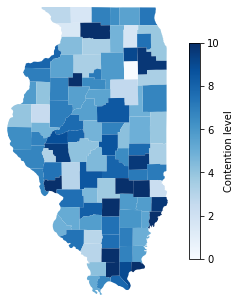

In [251]:
# Plot contention on a map of Illinois

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
color_scale = 'Blues'

ax.axis('off')
ax.margins(0)
vmin, vmax = 0, 10  # Contention is between 0 and 10 
sm = plt.cm.ScalarMappable(cmap=color_scale, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.025, label='Contention level')

geo_df.plot(ax=ax, column='contention', cmap=color_scale)
plt.savefig('WindAcceptance.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

## Turbines data

In [252]:
turbines_data = pd.read_csv('uswtdb_v4_2_20211101.csv')
turbines_data = turbines_data[turbines_data['t_state'] == 'IL'] 
min_n_turbines = turbines_data['p_tnum'].min()
max_n_turbines = turbines_data['p_tnum'].max()
mean_n_turbines = turbines_data['p_tnum'].mean()
std_n_turbines = turbines_data['p_tnum'].std()
min_t_rd = turbines_data['t_rd'].min()
max_t_rd = turbines_data['t_rd'].max()
mean_t_rd = turbines_data['t_rd'].mean()
std_t_rd = turbines_data['t_rd'].std()
t_rd_mdl_result = st_mdl.ols(formula="t_rd ~ p_year", data=turbines_data).fit().params
int_t_rd_mdl, coef_t_rd_mdl = t_rd_mdl_result['Intercept'], t_rd_mdl_result['p_year']
project_data = turbines_data.groupby('p_name').mean()
project_data = project_data.sort_values(by=['p_year'])
yearly_project_count = project_data['p_year'].value_counts(sort=False).to_frame()
yearly_project_count = yearly_project_count.sort_index(ascending=True)
yearly_project_count['cum_num_project'] = yearly_project_count['p_year'].cumsum()
yearly_project_count.reset_index(level=0, inplace=True)
p_mdl_result = st_mdl.ols(formula="cum_num_project ~ index", data=yearly_project_count).fit().params
yearly_projects = int(p_mdl_result['index'])
starting_year = turbines_data['p_year'].max()

## Setting up agents

In [253]:
count = 0
class WindAcceptanceModel(Model):
    def __init__(self,
                 seed: int = 0,
                 num_agents_init: int = yearly_projects,
                 environment: Type[gpd.GeoDataFrame] = geo_df,
                 states: list = ['non-sited', 'delayed', 'sited'],
                 learning_rate: float = 0.1,
                 discount: float = 0.95,
                 episodes: int = 100,
                 epsilon: float = 0.5,
                 start_epsilon_decaying: int = 1,
                 end_epsilon_decaying_factor: int = 2,
                 # source of x lines below is: 
                 # http://solidwize.com/wp-content/uploads/2013/07/7-Understanding-the-Wind-Power-Equation.pdf
                 power_coeff: float = 0.5,
                 air_density: float = 1.225,
                 starting_year: int = int(starting_year),
                 end_year: int = 2050,
                 time_delay: int = 1,
                 crowding_penalty = 0.5
                ) -> None:
        """
        Initiate model from input data.
        :param seed: number used to initialize the random generator.
        :param num_agents: number of agents.
        """
        # Assign inputs to instance variables
        self.seed = seed
        self.num_agents_init = num_agents_init
        self.environment = environment
        self.states = states
        self.learning_rate = learning_rate
        self.discount = discount
        self.episodes = episodes
        self.epsilon = epsilon
        self.start_epsilon_decaying = start_epsilon_decaying
        self.end_epsilon_decaying_factor = end_epsilon_decaying_factor
        self.power_coeff = power_coeff
        self.air_density = air_density
        self.starting_year = starting_year
        self.end_year = end_year
        self.time_delay = time_delay
        self.crowding_penalty = crowding_penalty

        # Initialize random seed
        random.seed(self.seed)
        self.reset_randomizer(self.seed)
        
        # Create model variables
        self.agent_id = 0
        self.schedule = RandomActivation(self)
        self.end_epsilon_decaying = self.episodes / end_epsilon_decaying_factor
        self.epsilon_decay_value = self.epsilon / (
            self.end_epsilon_decaying - self.start_epsilon_decaying)
        # Create the Q-table with a number of columns (actions) equal to the number of counties 
        # (siting choices) and the number of rows (states) equal to the state list defined above
        self.q_table = pd.DataFrame(0, index=self.states, columns=(self.environment['County'].unique()))
        self.q_table['delayed'] = 0
        self.min_t_rd = min_t_rd
        self.max_t_rd = max_t_rd
        self.mean_t_rd = mean_t_rd
        self.std_t_rd = std_t_rd
        self.clock = 0
        self.environment['n_turbines_installed'] = 0
        
        # Create initial agents
        self.adding_agents(self.num_agents_init, self.schedule, WindDeveloperAgent)
    
    def adding_agents(self, num_agents: int, schedule: Type[RandomActivation], 
                      agent_class: Type[Agent]) -> None:
        """
        Add agents to the schedule.
        :param num_agents: number of agents to add
        :param schedule: the schedule
        :param agent_class: the agent class
        """
        for agent in range(num_agents):
            a = agent_class(self.agent_id, self)
            schedule.add(a)
            self.agent_id += 1
    
    @staticmethod
    def increase_rotor_radius(min_t_rd, max_t_rd, mean_t_rd, std_t_rd, p_mdl_result):
        min_t_rd += p_mdl_result['index']
        max_t_rd += p_mdl_result['index']
        mean_t_rd += p_mdl_result['index']
        std_t_rd += p_mdl_result['index']
        return min_t_rd, max_t_rd, mean_t_rd, std_t_rd
        
    def step(self) -> None:
        """
        Advance the model by one step
        """
        self.schedule.step()
        self.min_t_rd, self.max_t_rd, self.mean_t_rd, self.std_t_rd = (
            self.increase_rotor_radius(self.min_t_rd, self.max_t_rd, 
                                       self.mean_t_rd, self.std_t_rd, p_mdl_result))
        self.adding_agents(yearly_projects, self.schedule, WindDeveloperAgent)
        self.clock += 1
            
class WindDeveloperAgent(Agent):
    def __init__(self, unique_id, model) -> None:
        super().__init__(unique_id, model)
        """
        Creation of new agent.
        """
        self.delay = 0
        self.old_state = 'non-sited'
        self.n_turbines = int(trunc_normal_distrib_draw(min_n_turbines, max_n_turbines, 
                                                    mean_n_turbines, std_n_turbines))
        self.t_rd = trunc_normal_distrib_draw(self.model.min_t_rd, self.model.max_t_rd, 
                                              self.model.mean_t_rd, self.model.std_t_rd)
        
    def place_turbines(self):
        if self.delay == 0:
            if np.random.random() > self.model.epsilon:
                maximums = self.model.q_table.idxmax(axis=1)
                action = maximums.loc[self.old_state]
            else:
                action = random.choice(self.model.q_table.columns)
            if action != 'delayed':
                new_state = 'sited'
                index_action = self.model.environment.index[self.model.environment['County'] == action]
                self.model.environment.loc[index_action, 'n_turbines_installed'] = (
                    self.model.environment.loc[index_action, 'n_turbines_installed'] + self.n_turbines)
            else:
                new_state = 'delayed'
            reward, new_state = self.reward_calculation(action, new_state)
        # TODO: Continue HERE - write the Q-learning function
        else:
            pass  # This will literally pass as the agent has to wait to make a decision
    
    def reward_calculation(self, action, new_state):
        # If wind developper delay siting, a negative reward is returned
        if action != 'delayed':
            # Power generated
            local_wind_speeds = self.model.environment[self.model.environment['County'] == action]
            local_wind_speed = local_wind_speeds.iloc[0]['wind_speed']
            power_reward = (self.model.power_coeff * self.model.air_density * pi * (self.t_rd / 2)**2 * 
                            local_wind_speed**3) / 1E6  # in MW
            # Logistic transformation (a more fitted transformation could be used eventually)
            power_reward = 1 / (1 + exp(-1 * power_reward))
            # Contention as a negative reward and risk of delay
            contentions = self.model.environment[self.model.environment['County'] == action]
            # Normalize contention between 0 and 1 (max contention is 10)
            contention = contentions.iloc[0]['contention'] / 10
            if np.random.random() > contention:
                power_n_contention_reward = power_reward
            else:
                power_n_contention_reward = power_reward - contention
                self.delay += self.model.time_delay
                new_state = 'delayed'
            # Crowding level as a negative reward
            index_action = self.model.environment.index[self.model.environment['County'] == action]
            existing_turbines = int(self.model.environment.loc[index_action, 'n_turbines_installed'])
            max_turbines = int(self.model.environment.loc[index_action, 'max_n_turbine'])
            crowding_level = min(existing_turbines / max_turbines, 1)
            reward = power_n_contention_reward - (self.model.crowding_penalty * crowding_level)
        else:
            reward = -1
        return reward, new_state
    
    def remove_agent(self):
        """
        Remove agent only if turbines are placed
        """
        if self.delay == 0:
            self.model.schedule.remove(self)
        else:
            self.delay -= 1

    def step(self) -> None:
        """
        Evolution of agent at each step
        """
        self.place_turbines()
        self.remove_agent()

        
run = WindAcceptanceModel()
time_steps = run.end_year - run.starting_year  # Period of the simulation
for time_step in range(time_steps):
    run.step()